<img src="img/Logo_OpenClassrooms.png" width=100 />

# OpenClassrooms Projet 5: Segmentez des clients d'un site e-commerce
# Modélisation

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


# Sommaire
### [Bibliothèques](#bibli)
### [Fonctions](#funcs)
### [Données](#donnees)
### [Centrage des données](#scaling)
### [Analyse en composantes principales](#PCA)
### [t-SNE](#tsne)
### [k-Means](#kmeans)
- [concordance k-Means, t-SNE](#concordance)

### [Tuning t-SNE](#tuning_tsne)
## V2
### [Données](#donnees_2)
### [Centrage des données](#scaling_2)
### [Analyse en composantes principales](#PCA_2)
### [t-SNE](#tsne_2)
### [k-Means](#kmeans_2)
- [concordance k-Means, t-SNE](#concordance_2)

### [Tuning t-SNE](#tuning_tsne_2)

### [DBSCAN](#DBSCAN_)
### [Clustering Hierarchique](#hierarchique)
### [Choix du modèle](#choix)

<a id='bibli'></a>
# Import de bibliothèques 📚

In [1]:
import pandas as pd

pd.set_option("mode.chained_assignment", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib setup 
plt.style.use('seaborn')
plt.rcParams["image.cmap"] = 'Accent'

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
from sklearn.neighbors import NearestCentroid

import mlflow

import time

from functions import *

In [2]:
import data_prep
import datetime
import pandas as pd

<a id='funcs'></a>

# Fonctions ⚙️

In [3]:
def scree_plot(data_scale, savefig=False):
    pca_scree = decomposition.PCA(n_components=data_scale.shape[1])
    pca_scree.fit(data_scale)
    plt.style.use('seaborn')
    plt.xlabel('Nb de Composantes Principales')
    plt.ylabel('Pourcentage de variance expliquée (cumulée)')
    plt.title('Scree plot PCA')
    plt.plot(np.arange(1, pca_scree.n_components_ + 1), pca_scree.explained_variance_ratio_.cumsum()*100)
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()

<a id='plot_spyder'></a>

In [4]:
def plot_spyder(pca, feature_names, lim=0.6, savefig=False):
    pcs = pca.components_
    plt.figure(figsize=(12,12))
    for i,(x,y) in enumerate(zip(pcs[0,:], pcs[1,:])):
        plt.plot([0,x], [0,y], color='purple')
        plt.text(x,y, feature_names[i], fontsize='14')
        plt.axis('equal')
    plt.plot([-lim,lim], [0,0], color='grey', ls='--')
    plt.plot([0,0], [-lim,lim], color='grey', ls='--')
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    plt.title('Spyder Plot')
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()

<a id='plot_scatter_tsne'></a>

In [5]:
def plot_scatter_tsne(data_tsne, loaded_model, data_scale, savefig=False):
    """Create figure with 2d projected data by tsne colored 
    by labels predicted by a kmeans model"""
    x = [point[0] for point in data_tsne]
    y = [point[1] for point in data_tsne]

    fig, ax = plt.subplots(figsize=(8,8))
    plt.axis('equal')
    plt.rcParams["image.cmap"] = 'Accent'
    scatter = ax.scatter(x, y, marker='o', s=15, c=loaded_model.predict(pd.DataFrame(data_scale)))
    legend1 = plt.legend(*scatter.legend_elements(),
                         loc="best", title="Classes", fontsize=12)
    ax.add_artist(legend1)
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()
    print(tsne.kl_divergence_)

In [6]:
def plot_scatter_tsne_seaborn(data_tsne, loaded_model, data_scale, savefig=False):
    """Create figure with 2d projected data by tsne colored 
    by labels predicted by a kmeans model"""
    
    df_subset = pd.DataFrame(data=data_tsne, columns=['x', 'y'])
    plt.figure(figsize=(8,8))
    plt.rcParams["image.cmap"] = 'Accent'
    
    plt.axis('equal')
    try:
        sns.scatterplot(x="x", 
                        y="y",
                        s=15,
                        hue=loaded_model.predict(pd.DataFrame(data_scale)),
                        palette=sns.color_palette("hls", len(set(loaded_model.labels_))),
                        data=df_subset,
                        legend="full")
    except Exception as e:
        sns.scatterplot(x="x", 
                        y="y",
                        s=15,
                        hue=loaded_model.fit_predict(pd.DataFrame(data_scale)),
                        palette=sns.color_palette("hls", len(set(loaded_model.labels_))),
                        data=df_subset,
                        legend="full")
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()
    print(tsne.kl_divergence_)

Retour au [code](#plot_scatter_tsne_back)

<a id='plot_perplexity_tsne'></a>

In [7]:
def plot_perplexity_tsne(tsne_data_save, 
                         loaded_model, 
                         data_scale,
                         color_from_labels=False, 
                         savefig=False):
    """"""
    fig, axes = plt.subplots(2,5, figsize=(25,10))
    axs = {5 : axes[0,0],
           10: axes[0,1],
           15: axes[0,2],
           20: axes[0,3],
           25: axes[0,4],
           30: axes[1,0],
           35: axes[1,1],
           40: axes[1,2],
           45: axes[1,3],
           50: axes[1,4]}
    for perplexity in np.arange(5,55,5):
        data_tsne_test = tsne_data_save[perplexity]
        df_subset = pd.DataFrame(data=data_tsne_test, columns=['x', 'y'])
        x = [point[0] for point in data_tsne_test]
        y = [point[1] for point in data_tsne_test]
        ax = axs[perplexity]
        ax.axis('equal')
        if color_from_labels:
            sns.scatterplot(ax=ax,
                            s=10,
                            x="x", 
                            y="y", 
                            hue=loaded_model.predict(pd.DataFrame(data_scale)),
                            palette=sns.color_palette("hls", len(set(list(loaded_model.predict(pd.DataFrame(data_scale)))))),
                            data=df_subset,
                            legend=False)
        else:
            ax.scatter(x, y, marker='.', s=10, 
                       color='purple')
        
        ax.set_title("Perplexity = {}".format(perplexity))
        ax.axis('equal')
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()

Retour au [code](#tuning_tsne)

<a id='launch_kmeans'></a>

In [8]:
def launch_kmeans(data, params, run_name):
    
    with mlflow.start_run(run_name=run_name):
        #Create an estimator
        model = KMeans(**params)
        #Save params
        for param, value in model.get_params().items():
            mlflow.log_param(param, value)
        #Fit
        start = time.time()
        model.fit(data)
        elapsed = time.time() - start
        
        
        #Save metrics
        mlflow.log_metric('inertia', model.inertia_)
        mlflow.log_metric('nb_iter', model.n_iter_)
        mlflow.log_metric('training_time', elapsed)
        mlflow.log_metric('silhouette_score', metrics.silhouette_score(data, model.labels_))
        mlflow.log_metric('davies_bouldin_score', metrics.davies_bouldin_score(data, model.labels_))
        
        
        #Save model
        mlflow.sklearn.log_model(model, "model")
        
        mlflow.end_run()
        
        return model

Retour au [code](#kmeans)

In [9]:
def plot_n_clust_against_metric(runs_df, metric, savefig=False):
    runs['params.n_clusters'] = runs['params.n_clusters'].astype('int')
    runs_df = runs_df.sort_values('params.n_clusters')
    plt.plot(runs_df['params.n_clusters'], runs_df[f'metrics.{metric}'])
    
    metric_nice = metric.replace('_', ' ').capitalize()
    plt.title(f'{metric_nice} selon le nb de clusters')
    plt.xlabel('Nb de clusters')
    plt.ylabel(metric_nice)
    plt.xticks(runs_df['params.n_clusters'])
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()

<a id='donnees'></a>

# Données 🎁

<img src="img/structure.png" width=500 />

Les données ont été travaillées pour etre rassemblées dans une base propre ayant pour index les ids des clients ayant fait 2 commandes ou plus. Les varaiables ont été crées pour représenter leurs comportemenst, leur satisfactions et leurs expériences

In [9]:
data = pd.read_csv("data/customer_data.csv", index_col=[0])

In [10]:
data.head()

nb_orders  days_since_first_order  \
customer_unique_id                                                    
00172711b30d52eea8b313a7f2cced02          2                      81   
004288347e5e88a27ded2bb23747066c          2                     447   
004b45ec5c64187465168251cd1c9c2f          2                     411   
0058f300f57d7b93c477a131a59b36c3          2                     240   
00a39521eb40f7012db50455bf083460          2                     146   

                                  days_since_last_order  frequency  \
customer_unique_id                                                   
00172711b30d52eea8b313a7f2cced02                     65   0.751543   
004288347e5e88a27ded2bb23747066c                    276   0.136186   
004b45ec5c64187465168251cd1c9c2f                    143   0.148114   
0058f300f57d7b93c477a131a59b36c3                    208   0.253646   
00a39521eb40f7012db50455bf083460                    136   0.416952   

                                  sum_orders  nb_reviews  \
customer_unique_id                                         
00172711b30d52eea8b313a7f2cced02       74.50         2.0   
004288347e5e88a27ded2bb23747066c      317.89         2.0   
004b45ec5c64187465168251cd1c9c2f       86.90         2.0   
0058f300f57d7b93c477a131a59b36c3      132.48         2.0   
00a39521eb40f7012db50455bf083460       81.45         2.0   

                                  average_review_score  average_delivery_time  \
customer_unique_id                                                              
00172711b30d52eea8b313a7f2cced02                   4.0                     11   
004288347e5e88a27ded2bb23747066c                   5.0                      7   
004b45ec5c64187465168251cd1c9c2f                   3.0                     22   
0058f300f57d7b93c477a131a59b36c3                   3.0                     13   
00a39521eb40f7012db50455bf083460                   4.0                     18   

                                  delay_rate  advance_rate  ...  stationery  \
customer_unique_id                                          ...               
00172711b30d52eea8b313a7f2cced02         0.0           1.0  ...           1   
004288347e5e88a27ded2bb23747066c         0.0           1.0  ...           0   
004b45ec5c64187465168251cd1c9c2f         0.0           1.0  ...           0   
0058f300f57d7b93c477a131a59b36c3         0.0           1.0  ...           0   
00a39521eb40f7012db50455bf083460         0.0           1.0  ...           0   

                                  tablets_printing_image  telephony  tools  \
customer_unique_id                                                           
00172711b30d52eea8b313a7f2cced02                       0          0      0   
004288347e5e88a27ded2bb23747066c                       0          0      0   
004b45ec5c64187465168251cd1c9c2f                       0          0      1   
0058f300f57d7b93c477a131a59b36c3                       0          0      0   
00a39521eb40f7012db50455bf083460                       0          0      0   

                                  toys  watches_gifts  cash  credit_card  \
customer_unique_id                                                         
00172711b30d52eea8b313a7f2cced02     0              0     0            0   
004288347e5e88a27ded2bb23747066c     0              0     0            1   
004b45ec5c64187465168251cd1c9c2f     0              0     1            0   
0058f300f57d7b93c477a131a59b36c3     0              0     0            0   
00a39521eb40f7012db50455bf083460     0              0     0            1   

                                  debit_card  voucher  
customer_unique_id                                     
00172711b30d52eea8b313a7f2cced02           0        1  
004288347e5e88a27ded2bb23747066c           0        0  
004b45ec5c64187465168251cd1c9c2f           0        0  
0058f300f57d7b93c477a131a59b36c3           0        1  
00a39521eb40f7012db50455bf083460           0        0  

[5 rows x 51 columns]

In [11]:
data.shape

(2997, 51)

In [12]:
data.columns

Index(['nb_orders', 'days_since_first_order', 'days_since_last_order',
       'frequency', 'sum_orders', 'nb_reviews', 'average_review_score',
       'average_delivery_time', 'delay_rate', 'advance_rate',
       'cancelation_rate', 'air_conditioning', 'appliances',
       'arts_and_craftmanship', 'audio', 'auto', 'baby', 'books',
       'christmas_supplies', 'cine_photo', 'computers', 'consoles_games',
       'cool_stuff', 'diapers_and_hygiene', 'dvds_blu_ray', 'electronics',
       'fashion', 'food_drink', 'furniture', 'health_beauty', 'home_confort',
       'home_construction', 'housewares', 'industry', 'luggage_accessories',
       'market_place', 'music', 'other', 'pet_shop', 'signaling_and_security',
       'sports_leisure', 'stationery', 'tablets_printing_image', 'telephony',
       'tools', 'toys', 'watches_gifts', 'cash', 'credit_card', 'debit_card',
       'voucher'],
      dtype='object')

In [13]:
cols_numeric = data.loc[:,:'cancelation_rate'].columns
cols_categ = data.loc[:,'air_conditioning':].columns

<a id='scaling'></a>
# Centrage des données 📊

D'après la théorie de l'analyse en composante principale, pour pouvoir projeter nos données dans une base orthonormée de plus faible dimension alors la matrice des données doit être normée elle aussi

In [14]:
scaler = StandardScaler()

In [15]:
scaler.fit(data[cols_numeric])

StandardScaler()

In [16]:
scaler.transform(data[cols_numeric]).shape

(2997, 11)

In [17]:
data_scale = pd.concat([pd.DataFrame(data=scaler.transform(data[cols_numeric]), index=data.index, columns=cols_numeric), data[cols_categ]], axis=1)

In [18]:
data_scale

nb_orders  days_since_first_order  \
customer_unique_id                                                    
00172711b30d52eea8b313a7f2cced02  -0.224803               -1.852280   
004288347e5e88a27ded2bb23747066c  -0.224803                0.617311   
004b45ec5c64187465168251cd1c9c2f  -0.224803                0.374401   
0058f300f57d7b93c477a131a59b36c3  -0.224803               -0.779425   
00a39521eb40f7012db50455bf083460  -0.224803               -1.413691   
...                                     ...                     ...   
ff36be26206fffe1eb37afd54c70e18b   1.711215               -1.852280   
ff44401d0d8f5b9c54a47374eb48c1b8  -0.224803                1.076142   
ff8892f7c26aa0446da53d01b18df463  -0.224803                1.049152   
ff922bdd6bafcdf99cb90d7f39cea5b3   1.711215                1.663176   
ffe254cc039740e17dd15a5305035928  -0.224803                1.400023   

                                  days_since_last_order  frequency  \
customer_unique_id                                                   
00172711b30d52eea8b313a7f2cced02              -1.398262   3.087087   
004288347e5e88a27ded2bb23747066c               0.053624  -0.585370   
004b45ec5c64187465168251cd1c9c2f              -0.861546  -0.514179   
0058f300f57d7b93c477a131a59b36c3              -0.414282   0.115633   
00a39521eb40f7012db50455bf083460              -0.909712   1.090245   
...                                                 ...        ...   
ff36be26206fffe1eb37afd54c70e18b              -1.467072   5.329693   
ff44401d0d8f5b9c54a47374eb48c1b8               1.698178  -0.692685   
ff8892f7c26aa0446da53d01b18df463               0.383911  -0.687163   
ff922bdd6bafcdf99cb90d7f39cea5b3               0.893103  -0.492888   
ffe254cc039740e17dd15a5305035928               2.028465  -0.752829   

                                  sum_orders  nb_reviews  \
customer_unique_id                                         
00172711b30d52eea8b313a7f2cced02   -0.600943   -0.389069   
004288347e5e88a27ded2bb23747066c    0.188105   -0.389069   
004b45ec5c64187465168251cd1c9c2f   -0.560744   -0.389069   
0058f300f57d7b93c477a131a59b36c3   -0.412978   -0.389069   
00a39521eb40f7012db50455bf083460   -0.578412   -0.389069   
...                                      ...         ...   
ff36be26206fffe1eb37afd54c70e18b   -0.589921    1.027748   
ff44401d0d8f5b9c54a47374eb48c1b8   -0.713438   -0.389069   
ff8892f7c26aa0446da53d01b18df463    0.058623    1.027748   
ff922bdd6bafcdf99cb90d7f39cea5b3   -0.535165    1.027748   
ffe254cc039740e17dd15a5305035928   -0.676869   -0.389069   

                                  average_review_score  average_delivery_time  \
customer_unique_id                                                              
00172711b30d52eea8b313a7f2cced02             -0.085903              -0.131181   
004288347e5e88a27ded2bb23747066c              0.783741              -0.691820   
004b45ec5c64187465168251cd1c9c2f             -0.955547               1.410577   
0058f300f57d7b93c477a131a59b36c3             -0.955547               0.149139   
00a39521eb40f7012db50455bf083460             -0.085903               0.849938   
...                                                ...                    ...   
ff36be26206fffe1eb37afd54c70e18b             -0.955547               0.008979   
ff44401d0d8f5b9c54a47374eb48c1b8             -0.955547               0.008979   
ff8892f7c26aa0446da53d01b18df463             -1.245428               3.512974   
ff922bdd6bafcdf99cb90d7f39cea5b3              0.203978               0.709778   
ffe254cc039740e17dd15a5305035928             -0.955547               0.709778   

                                  delay_rate  advance_rate  ...  stationery  \
customer_unique_id                                          ...               
00172711b30d52eea8b313a7f2cced02   -0.300228      0.398466  ...           1   
004288347e5e88a27ded2bb23747066c   -0.300228      0.398466  ...           0   
004b45ec5c64187465168251cd1c9c2f   -0.300228    

<a id='PCA'></a>
# Analyse en composantes principales ☘️

Sans les données catégoriques

In [19]:
pca_simple = decomposition.PCA(n_components=3)
pca_simple.fit(data_scale[cols_numeric])
print(pca_simple.explained_variance_ratio_.cumsum())

[0.23364062 0.45150694 0.61880425]


Avec les données catégoriques

In [20]:
pca = decomposition.PCA(n_components=3)
pca.fit(data_scale)
print(pca.explained_variance_ratio_.cumsum())

[0.20835307 0.4027918  0.55198789]


On explique 55% de la variance avec trois composantes principales

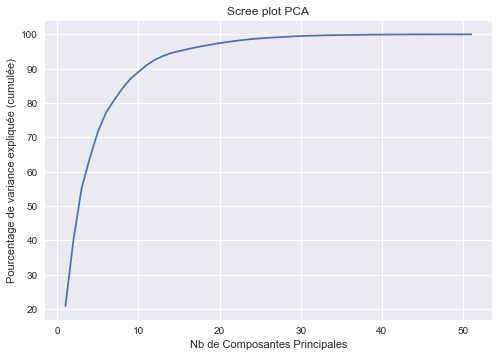

In [21]:
scree_plot(data_scale, savefig='scree_plot')

Voir la [fonction plot_spyder](#plot_spyder)

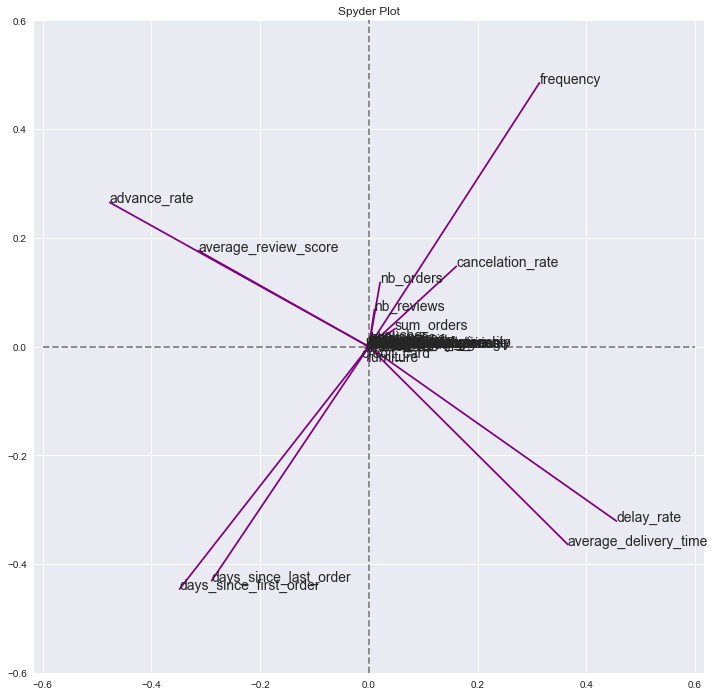

In [22]:
plot_spyder(pca, data_scale.columns, lim=0.6, savefig='spyder_plot_pca')

Retirer les features nb_orders, nb_reviews, sum_orders. On verra plus tard pour les catégories

<a id='tsne'></a>
# t-SNE ✨

Données non standardisées

In [23]:
%%time
tsne_raw = manifold.TSNE(random_state=41)
data_tsne_raw = tsne_raw.fit_transform(data)

Wall time: 16.4 s


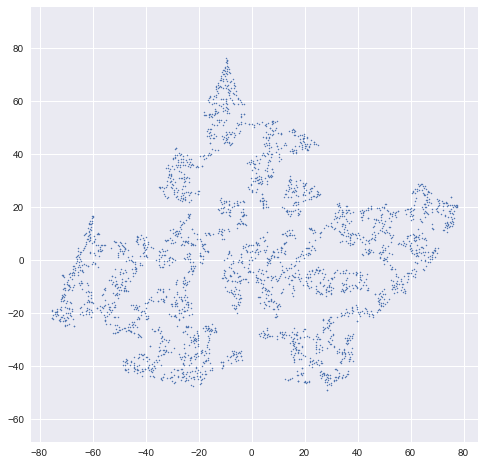

0.8501572012901306


In [24]:
x = [point[0] for point in data_tsne_raw]
y = [point[1] for point in data_tsne_raw]
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne_raw.kl_divergence_)

Données Standardisées

In [25]:
%%time
tsne = manifold.TSNE(init='pca', random_state=41, n_jobs=-1)
data_tsne = tsne.fit_transform(data_scale)

Wall time: 18.2 s


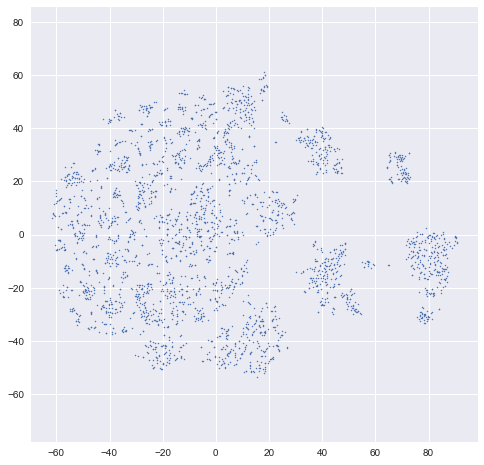

1.30453360080719


In [26]:
x = [point[0] for point in data_tsne]
y = [point[1] for point in data_tsne]
plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne.kl_divergence_)

On voit bien ici l'intéret de travailler sur des données standardisées

Fit un kmeans et colorier les points avec les etiquettes du kmeans et vérifier la cohérence du t-sne vis à vis du kmeans. Ensuite essayer la perplexité

<a id='kmeans'></a>
# k-Means 🧶

mlflow.set_experiment('k_Means')
for n_clusters in np.arange(19,26):
    launch_kmeans(data_scale, {'n_clusters':n_clusters, 'random_state':41}, 'GS_sil_db{}'.format(n_clusters))

Voir la [fonction](#launch_kmeans)

In [27]:
runs = mlflow.search_runs('1')

In [28]:
runs[runs['tags.mlflow.runName']!='test'][['tags.mlflow.runName', 'params.n_clusters', 'metrics.inertia', 'metrics.silhouette_score']].sort_values('metrics.silhouette_score', ascending=False)

tags.mlflow.runName params.n_clusters  metrics.inertia  \
32             GS_sil_2                 2     31150.634832   
23           GS_sil_db2                 2     31150.634832   
29             GS_sil_5                 5     21633.441276   
20           GS_sil_db5                 5     21633.441276   
30             GS_sil_4                 4     24247.857397   
..                  ...               ...              ...   
228                GS_5                 5     21633.441276   
229                GS_4                 4     24247.857397   
230                GS_3                 3     26977.036396   
231                GS_2                 2     31150.634832   
232                GS_1                 1     36994.289957   

     metrics.silhouette_score  
32                   0.369910  
23                   0.369910  
29                   0.193952  
20                   0.193952  
30                   0.189334  
..                        ...  
228                       NaN  
229                       NaN  
230                       NaN  
231                       NaN  
232                       NaN  

[233 rows x 4 columns]

In [29]:
runs.artifact_uri.iloc[0] + '/model'

'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/618a8111a0c54a999e258e3b3f7934b4/artifacts/model'

<a id='concordance'></a>
## Concordance k-Means avec t-SNE 🧬

### Avec 5 clusters

In [38]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/c9520ad7bef0449d81f2c0b697be3a2a/artifacts/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.sklearn.load_model(logged_model)

<a id='plot_scatter_tsne_back'></a>

5


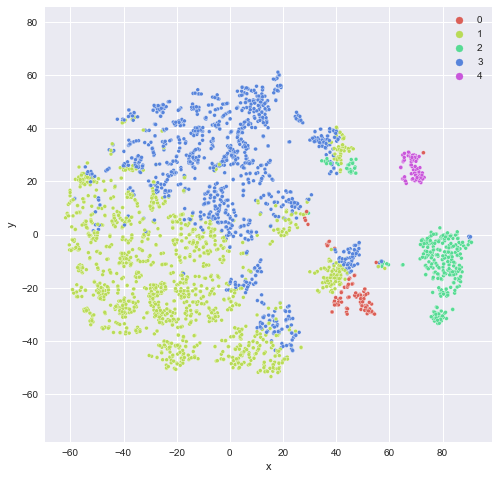

1.30453360080719


In [39]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model, data_scale)  

Voir [fonction](#plot_scatter_tsne)

### Avec 2 clusters

In [40]:
logged_model_2 = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/af4f2361d4744d7598403f4e0067f92c/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_2 = mlflow.sklearn.load_model(logged_model_2)


C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


2


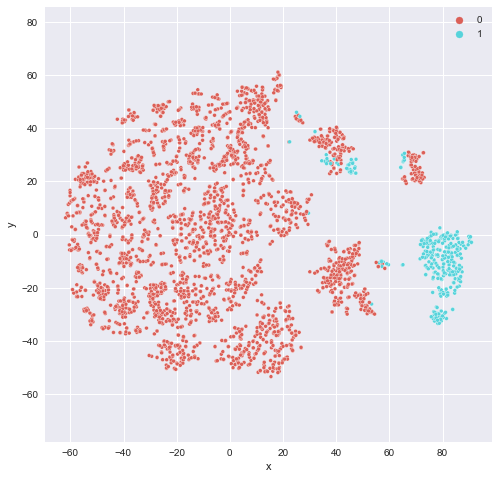

1.30453360080719


In [41]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_2, data_scale)    

### Avec 10 clusters

In [42]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/7e84e7aff2a24088bcec17d3813f9dd8/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_10 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


10


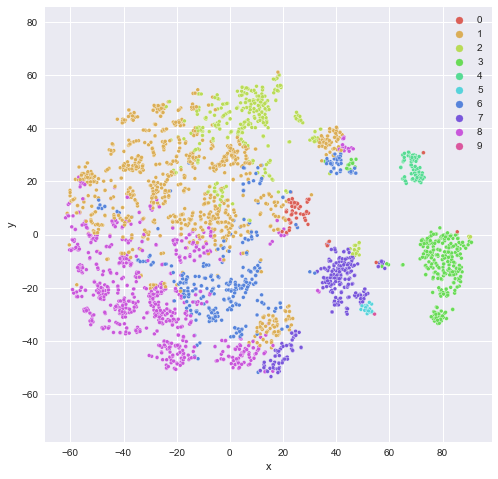

1.30453360080719


In [43]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_10, data_scale)   

### Avec 11 clusters

In [44]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/376fbc189978476ea81ffcbc153a5b03/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_11 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


11


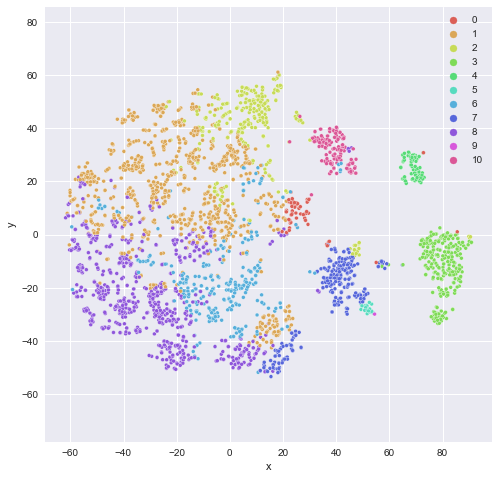

1.30453360080719


In [45]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_11, data_scale)    

### Avec 15 clusters

In [46]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/9eab375a8ce2445fa75c3ae087d4bcf5/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_15 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


15


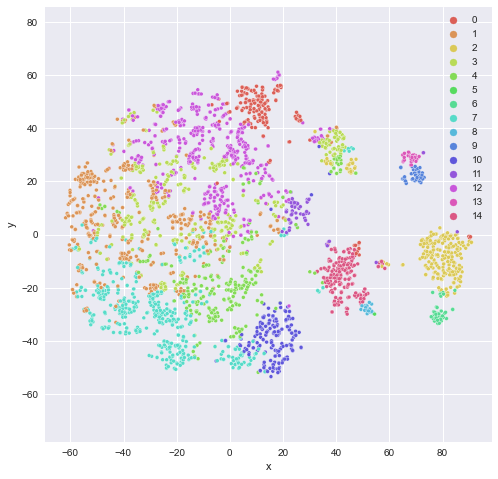

1.30453360080719


In [47]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_15, data_scale)    

<a id='tuning_tsne'></a>
# Tentative d'amélioration du t-SNE

Nous allons visuellement tuner la perplexité de t-SNE en tracant les projections

In [48]:
tsne_data_save = {}
for perplexity in np.arange(5,55,5):
    tsne_test = manifold.TSNE(init='pca', 
                              random_state=41, 
                              n_jobs=-1, 
                              perplexity=perplexity)
    data_tsne_test = tsne_test.fit_transform(data_scale)
    tsne_data_save[perplexity] = data_tsne_test

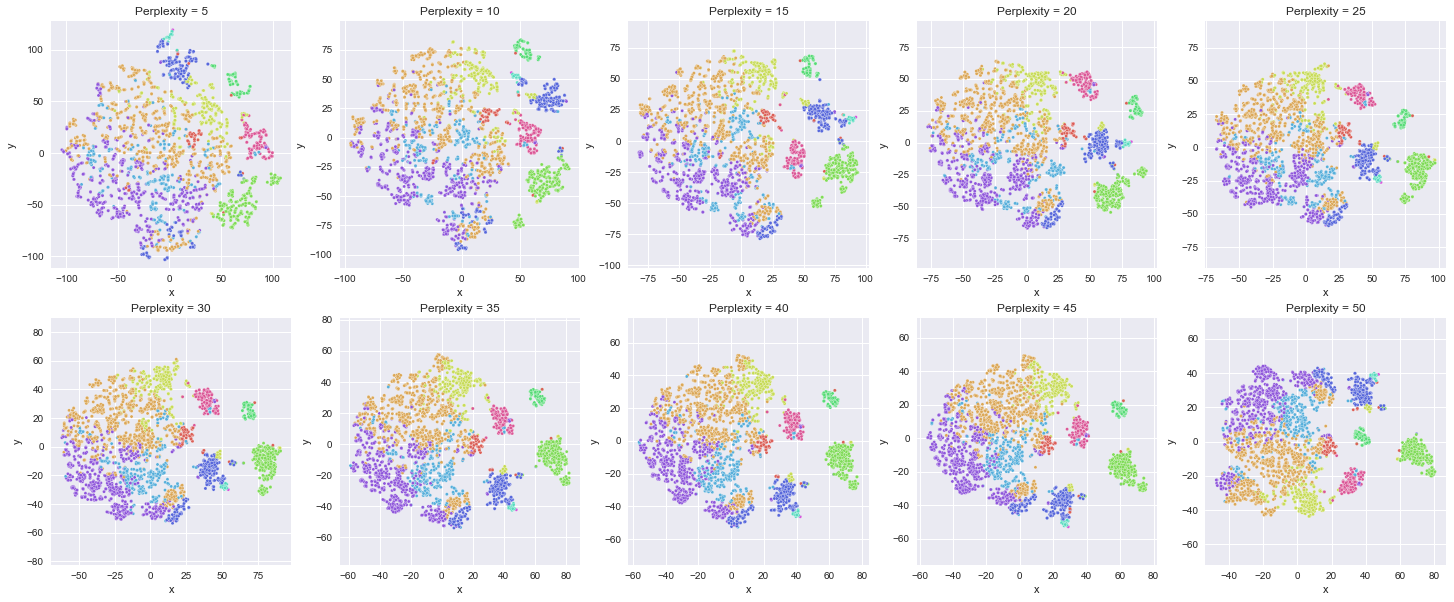

In [49]:
plot_perplexity_tsne(tsne_data_save,
                     loaded_model_11,
                     data_scale,
                     color_from_labels=True)

Voir la [fonction](#plot_perplexity_tsne)


Les resultats sont peu satisfaisants même si on en a appris un peu sur nos données. Nous allons refaire l'étude avec une version des données ayant une plus petite dimension. Nous avons retravaillé la donnée "categorie preferee" et diminué sa cardinalité de 36 à 16.

# IDEM avec les données V2

<a id='donnees_2'></a>

# Données 🎁

In [50]:
data = pd.read_csv("data/customer_data_v_2.csv", index_col=[0])

In [51]:
data.head()

nb_orders  days_since_first_order  \
customer_unique_id                                                    
00172711b30d52eea8b313a7f2cced02          2                      81   
004288347e5e88a27ded2bb23747066c          2                     447   
004b45ec5c64187465168251cd1c9c2f          2                     411   
0058f300f57d7b93c477a131a59b36c3          2                     240   
00a39521eb40f7012db50455bf083460          2                     146   

                                  days_since_last_order  frequency  \
customer_unique_id                                                   
00172711b30d52eea8b313a7f2cced02                     65   0.751543   
004288347e5e88a27ded2bb23747066c                    276   0.136186   
004b45ec5c64187465168251cd1c9c2f                    143   0.148114   
0058f300f57d7b93c477a131a59b36c3                    208   0.253646   
00a39521eb40f7012db50455bf083460                    136   0.416952   

                                  sum_orders  nb_reviews  \
customer_unique_id                                         
00172711b30d52eea8b313a7f2cced02       74.50         2.0   
004288347e5e88a27ded2bb23747066c      317.89         2.0   
004b45ec5c64187465168251cd1c9c2f       86.90         2.0   
0058f300f57d7b93c477a131a59b36c3      132.48         2.0   
00a39521eb40f7012db50455bf083460       81.45         2.0   

                                  average_review_score  average_delivery_time  \
customer_unique_id                                                              
00172711b30d52eea8b313a7f2cced02                   4.0                     11   
004288347e5e88a27ded2bb23747066c                   5.0                      7   
004b45ec5c64187465168251cd1c9c2f                   3.0                     22   
0058f300f57d7b93c477a131a59b36c3                   3.0                     13   
00a39521eb40f7012db50455bf083460                   4.0                     18   

                                  delay_rate  advance_rate  ...  \
customer_unique_id                                          ...   
00172711b30d52eea8b313a7f2cced02         0.0           1.0  ...   
004288347e5e88a27ded2bb23747066c         0.0           1.0  ...   
004b45ec5c64187465168251cd1c9c2f         0.0           1.0  ...   
0058f300f57d7b93c477a131a59b36c3         0.0           1.0  ...   
00a39521eb40f7012db50455bf083460         0.0           1.0  ...   

                                  home_construction  industry  other  \
customer_unique_id                                                     
00172711b30d52eea8b313a7f2cced02                  0         0      0   
004288347e5e88a27ded2bb23747066c                  0         0      0   
004b45ec5c64187465168251cd1c9c2f                  1         0      0   
0058f300f57d7b93c477a131a59b36c3                  0         0      0   
00a39521eb40f7012db50455bf083460                  0         0      0   

                                  pet_shop  sports_leisure  \
customer_unique_id                                           
00172711b30d52eea8b313a7f2cced02         0               0   
004288347e5e88a27ded2bb23747066c         0               0   
004b45ec5c64187465168251cd1c9c2f         0               0   
0058f300f57d7b93c477a131a59b36c3         0               0   
00a39521eb40f7012db50455bf083460         0               0   

                                  watches_gifts_toys  cash  credit_card  \
customer_unique_id                                                        
00172711b30d52eea8b313a7f2cced02                   0     0            1   
004288347e5e88a27ded2bb23747066c                   1     0            1   
004b45ec5c64187465168251cd1c9c2f                   0     1            0   
0058f300f57d7b93c477a131a59b36c3                   0     0            0   
00a39521eb40f7012db50455bf083460                   0     0            1   

                                  debit_card  voucher  
customer_unique_id                                     
00172711

In [52]:
data.shape

(2997, 31)

D'après le premier spyder plot, certaines colonnes n'apportent pas grand chose à notre problématique de clustering

In [53]:
data.drop(columns=['nb_orders', 'nb_reviews', 'sum_orders'], inplace=True)

In [54]:
data.columns

Index(['days_since_first_order', 'days_since_last_order', 'frequency',
       'average_review_score', 'average_delivery_time', 'delay_rate',
       'advance_rate', 'cancelation_rate', 'arts_and_craftmanship', 'auto',
       'baby', 'culture', 'electronics', 'fashion', 'food_drink', 'furniture',
       'health_beauty', 'home_confort', 'home_construction', 'industry',
       'other', 'pet_shop', 'sports_leisure', 'watches_gifts_toys', 'cash',
       'credit_card', 'debit_card', 'voucher'],
      dtype='object')

In [55]:
cols_numeric = data.loc[:,:'cancelation_rate'].columns
cols_categ = data.loc[:,'arts_and_craftmanship':].columns

In [56]:
cols_categ

Index(['arts_and_craftmanship', 'auto', 'baby', 'culture', 'electronics',
       'fashion', 'food_drink', 'furniture', 'health_beauty', 'home_confort',
       'home_construction', 'industry', 'other', 'pet_shop', 'sports_leisure',
       'watches_gifts_toys', 'cash', 'credit_card', 'debit_card', 'voucher'],
      dtype='object')

<a id='scaling_2'></a>
# Centrage des données 📊

D'après la théorie de l'analyse en composante principale, pour pouvoir projeter nos données dans une base orthonormée de plus faible dimension alors la matrice des données doit être normée elle aussi

In [57]:
scaler = StandardScaler()

In [58]:
scaler.fit(data[cols_numeric])

StandardScaler()

In [59]:
scaler.transform(data[cols_numeric]).shape

(2997, 8)

In [60]:
data_scale = pd.concat([pd.DataFrame(data=scaler.transform(data[cols_numeric]), index=data.index, columns=cols_numeric), data[cols_categ]], axis=1)

In [61]:
data_scale

days_since_first_order  \
customer_unique_id                                         
00172711b30d52eea8b313a7f2cced02               -1.852280   
004288347e5e88a27ded2bb23747066c                0.617311   
004b45ec5c64187465168251cd1c9c2f                0.374401   
0058f300f57d7b93c477a131a59b36c3               -0.779425   
00a39521eb40f7012db50455bf083460               -1.413691   
...                                                  ...   
ff36be26206fffe1eb37afd54c70e18b               -1.852280   
ff44401d0d8f5b9c54a47374eb48c1b8                1.076142   
ff8892f7c26aa0446da53d01b18df463                1.049152   
ff922bdd6bafcdf99cb90d7f39cea5b3                1.663176   
ffe254cc039740e17dd15a5305035928                1.400023   

                                  days_since_last_order  frequency  \
customer_unique_id                                                   
00172711b30d52eea8b313a7f2cced02              -1.398262   3.087087   
004288347e5e88a27ded2bb23747066c               0.053624  -0.585370   
004b45ec5c64187465168251cd1c9c2f              -0.861546  -0.514179   
0058f300f57d7b93c477a131a59b36c3              -0.414282   0.115633   
00a39521eb40f7012db50455bf083460              -0.909712   1.090245   
...                                                 ...        ...   
ff36be26206fffe1eb37afd54c70e18b              -1.467072   5.329693   
ff44401d0d8f5b9c54a47374eb48c1b8               1.698178  -0.692685   
ff8892f7c26aa0446da53d01b18df463               0.383911  -0.687163   
ff922bdd6bafcdf99cb90d7f39cea5b3               0.893103  -0.492888   
ffe254cc039740e17dd15a5305035928               2.028465  -0.752829   

                                  average_review_score  average_delivery_time  \
customer_unique_id                                                              
00172711b30d52eea8b313a7f2cced02             -0.085903              -0.131181   
004288347e5e88a27ded2bb23747066c              0.783741              -0.691820   
004b45ec5c64187465168251cd1c9c2f             -0.955547               1.410577   
0058f300f57d7b93c477a131a59b36c3             -0.955547               0.149139   
00a39521eb40f7012db50455bf083460             -0.085903               0.849938   
...                                                ...                    ...   
ff36be26206fffe1eb37afd54c70e18b             -0.955547               0.008979   
ff44401d0d8f5b9c54a47374eb48c1b8             -0.955547               0.008979   
ff8892f7c26aa0446da53d01b18df463             -1.245428               3.512974   
ff922bdd6bafcdf99cb90d7f39cea5b3              0.203978               0.709778   
ffe254cc039740e17dd15a5305035928             -0.955547               0.709778   

                                  delay_rate  advance_rate  cancelation_rate  \
customer_unique_id                                                             
00172711b30d52eea8b313a7f2cced02   -0.300228      0.398466          5.672887   
004288347e5e88a27ded2bb23747066c   -0.300228      0.398466         -0.164253   
004b45ec5c64187465168251cd1c9c2f   -0.300228      0.398466         -0.164253   
0058f300f57d7b93c477a131a59b36c3   -0.300228      0.398466          5.672887   
00a39521eb40f7012db50455bf083460   -0.300228      0.398466         -0.164253   
...                                      ...           ...               ...   
ff36be26206fffe1eb37afd54c70e18b   -0.300228     -3.952728          7.618601   
ff44401d0d8f5b9c54a47374eb48c1b8   -0.300228      0.398466         -0.164253   
ff8892f7c26aa0446da53d01b18df463    2.654544     -1.777131         -0.164253   
ff922bdd6bafcdf99cb90d7f39cea5b3    1.669620     -1.051932         -0.164253   
ffe254cc039740e17dd15a5305035928   -0.300228      0.398466         -0.164253   

                                  arts_and_craftmanship  auto  ...  \
customer_unique_id                                             ...   
00172711b30d52eea8b313a7f2cced02                      1     0  ...   
004288347e5e88a27ded2bb23747066c     

<a id='PCA_2'></a>
# Analyse en composantes principales ☘️

Sans les données catégoriques

In [62]:
pca_simple = decomposition.PCA(n_components=3)
pca_simple.fit(data_scale[cols_numeric])
print(pca_simple.explained_variance_ratio_.cumsum())

[0.32080532 0.61867226 0.75233877]


Avec les données catégoriques

In [63]:
pca = decomposition.PCA(n_components=3)
pca.fit(data_scale)
print(pca.explained_variance_ratio_.cumsum())

[0.27671454 0.53391039 0.64953068]


On explique 65% de la variance avec trois composantes principales, c'est une nette amélioration

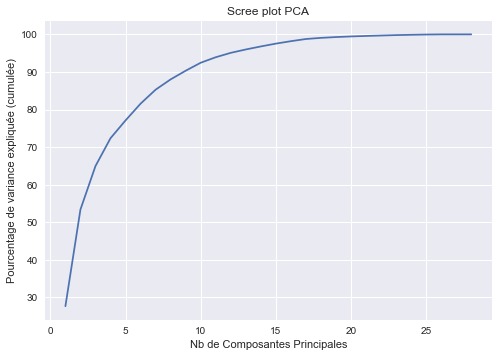

In [64]:
scree_plot(data_scale, savefig='scree_plot_2')

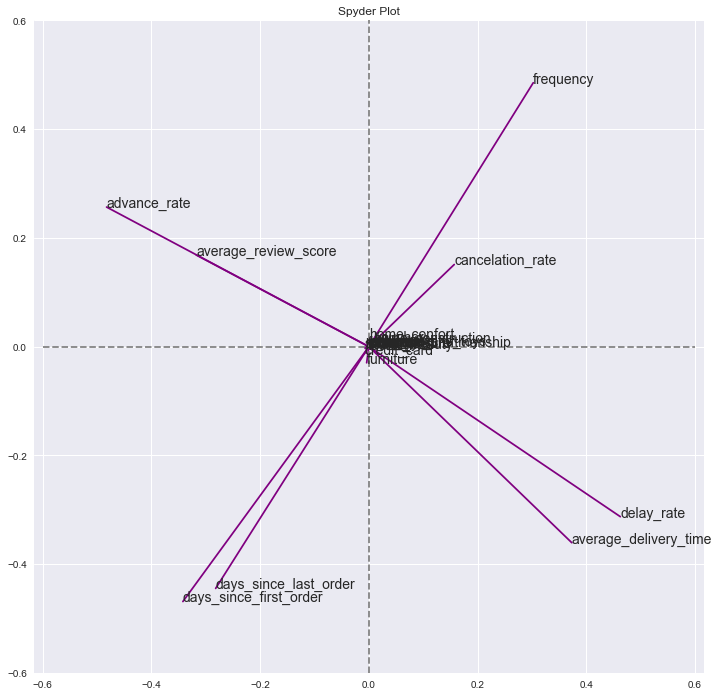

In [65]:
plot_spyder(pca, data_scale.columns, lim=0.6, savefig='spyder_plot_pca_2')

<a id='tsne_2'></a>
# t-SNE ✨

Données non standardisées

In [66]:
%%time
tsne_raw = manifold.TSNE(random_state=41)
data_tsne_raw = tsne_raw.fit_transform(data)

Wall time: 15.8 s


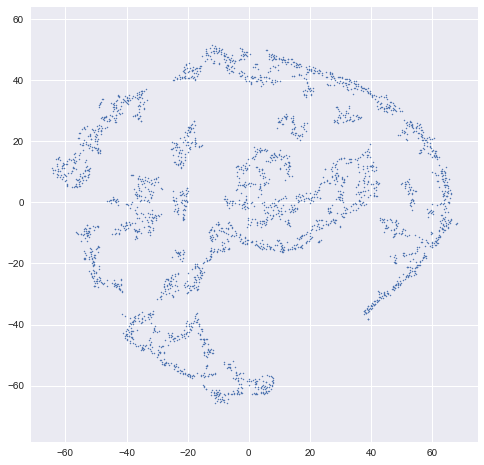

0.5255255699157715


In [67]:
x = [point[0] for point in data_tsne_raw]
y = [point[1] for point in data_tsne_raw]
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne_raw.kl_divergence_)

Données Standardisées

In [68]:
%%time
tsne = manifold.TSNE(init='pca', random_state=41, n_jobs=-1)
data_tsne = tsne.fit_transform(data_scale)

Wall time: 15.4 s


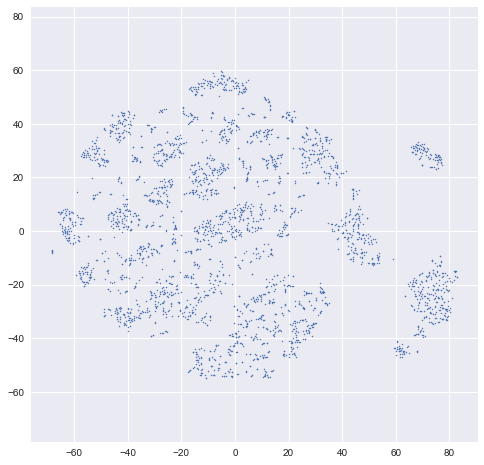

1.1345088481903076


In [69]:
x = [point[0] for point in data_tsne]
y = [point[1] for point in data_tsne]
plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne.kl_divergence_)

EST CE MIEUX???

<a id='kmeans_2'></a>
# k-Means 🧶

Voir la [fonction](#launch_kmeans)

In [70]:
runs = mlflow.search_runs('3')

In [71]:
runs.columns


Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.inertia', 'metrics.silhouette_score',
       'metrics.davies_bouldin_score', 'metrics.training_time',
       'metrics.nb_iter', 'params.init', 'params.tol',
       'params.precompute_distances', 'params.verbose', 'params.random_state',
       'params.n_jobs', 'params.n_init', 'params.n_clusters',
       'params.algorithm', 'params.max_iter', 'params.copy_x',
       'tags.mlflow.runName', 'tags.mlflow.user', 'tags.mlflow.source.name',
       'tags.mlflow.source.type', 'tags.mlflow.log-model.history'],
      dtype='object')

In [72]:
runs[runs['tags.mlflow.runName']!='test'][['tags.mlflow.runName', 'params.n_clusters', 'metrics.inertia', 'metrics.silhouette_score', "metrics.davies_bouldin_score"]].sort_values('metrics.silhouette_score', ascending=False)

tags.mlflow.runName params.n_clusters  metrics.inertia  \
23          GS_sil_db2                 2     21968.986587   
21          GS_sil_db4                 4     15101.879364   
22          GS_sil_db3                 3     17814.738844   
18          GS_sil_db7                 7     12108.044977   
20          GS_sil_db5                 5     13678.640477   
19          GS_sil_db6                 6     12746.426180   
13         GS_sil_db12                12      9701.475832   
14         GS_sil_db11                11     10215.797406   
16          GS_sil_db9                 9     10980.042781   
15         GS_sil_db10                10     10599.020244   
17          GS_sil_db8                 8     11494.669996   
11         GS_sil_db14                14      9186.394520   
12         GS_sil_db13                13      9424.963887   
10         GS_sil_db15                15      8951.672635   
5          GS_sil_db20                20      8202.767783   
9          GS_sil_db16                16      8779.434854   
6          GS_sil_db19                19      8312.979313   
4          GS_sil_db21                21      8052.692171   
1          GS_sil_db24                24      7744.230664   
0          GS_sil_db25                25      7648.389510   
3          GS_sil_db22                22      7955.459945   
2          GS_sil_db23                23      7865.874898   
8          GS_sil_db17                17      8641.035647   
7          GS_sil_db18                18      8506.398287   

    metrics.silhouette_score  metrics.davies_bouldin_score  
23                  0.423249                      1.210210  
21                  0.227689                      1.286264  
22                  0.222381                      1.476517  
18                  0.181039                      1.438008  
20                  0.180755                      1.439356  
19                  0.180720                      1.436423  
13                  0.160464                      1.561426  
14                  0.157593                      1.582964  
16                  0.156458                      1.516787  
15                  0.156027                      1.575318  
17                  0.153901                      1.541820  
11                  0.151076                      1.537311  
12                  0.150069                      1.571681  
10                  0.143820                      1.606529  
5                   0.143392                      1.638619  
9                   0.141419                      1.649523  
6                   0.139910                      1.649615  
4                   0.132466                      1.671514  
1                   0.131510                      1.705433  
0                   0.130174                      1.717165  
3                   0.130077                      1.706534  
2                   0.129198                      1.706759  
8                   0.125748                      1.635044  
7                   0.123832                      1.684101

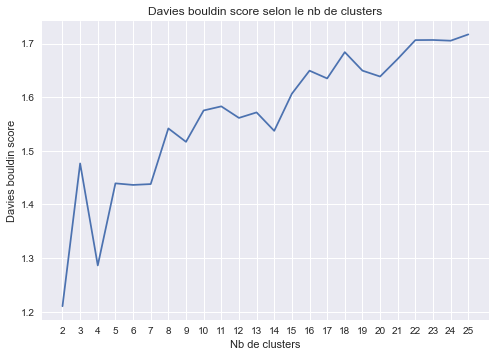

In [73]:
plot_n_clust_against_metric(runs, 'davies_bouldin_score', savefig='db_clust_kmeans_v2')

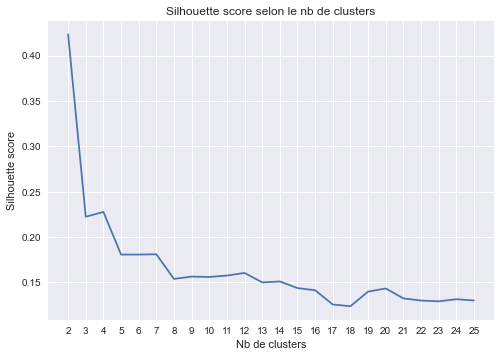

In [74]:
plot_n_clust_against_metric(runs, 'silhouette_score', savefig='silh_clust_kmeans_v2')

<a id='concordance_2'></a>
## Concordance k-Means avec t-SNE 🧬

### Avec 4 clusters

In [75]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/3/4d1b1b46e84c465fa04d43b52891acb3/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_v2_4 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


<a id='plot_scatter_tsne_back'></a>

4


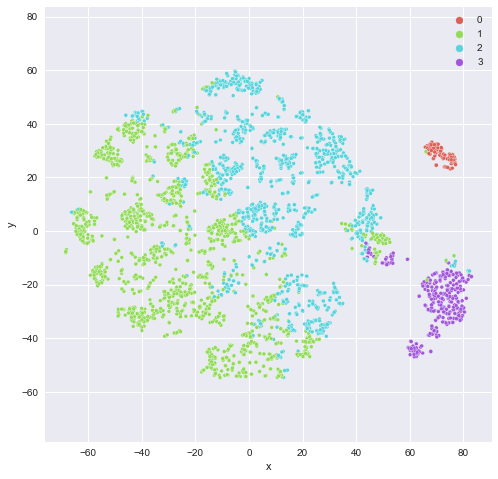

1.1345088481903076


In [76]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_v2_4, data_scale)  

Voir [fonction](#plot_scatter_tsne)

### Avec 2 clusters

In [77]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/3/d2fe6b00aa064fa18a02cad79c23ec4a/artifacts/model'


# Load model as a PyFuncModel.
loaded_model_v2_2 = mlflow.sklearn.load_model(logged_model)


C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


2


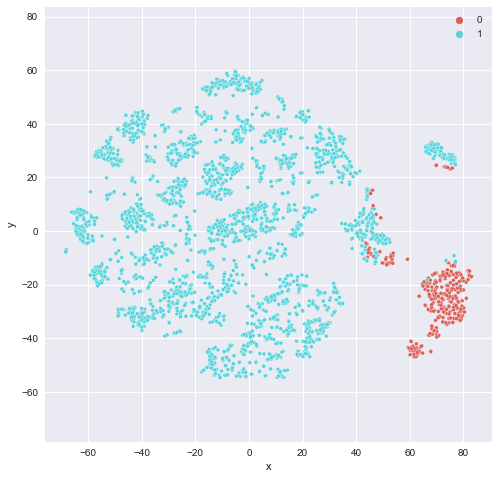

1.1345088481903076


In [78]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_v2_2, data_scale)    

### Avec 7 clusters

In [79]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/3/8a5a1158a1a74e69a781c9e2c8ab4206/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_v2_7 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


7


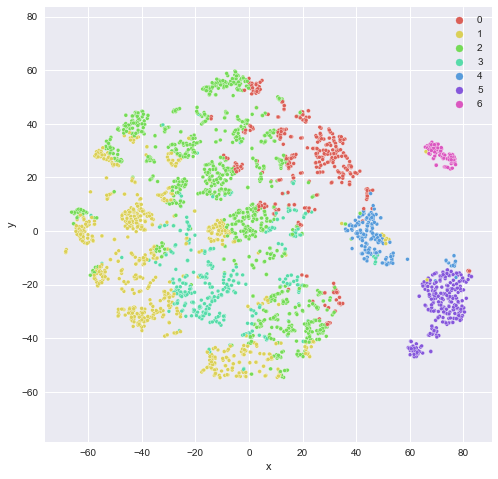

1.1345088481903076


In [80]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_v2_7, data_scale)   

### Avec 3 clusters

In [81]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/3/5319ccfb58b04be8be46fa3a7753499e/artifacts/model'


# Load model as a PyFuncModel.
loaded_model_v2_3 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


3


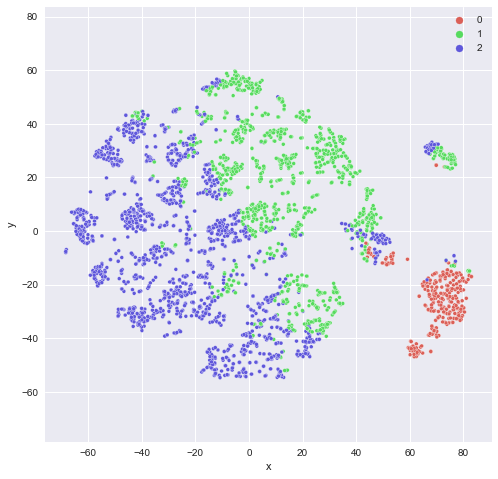

1.1345088481903076


In [82]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_v2_3, data_scale)    

<a id='tuning_tsne_2'></a>
# Tentative d'amélioration du t-SNE

Nous allons visuellement tuner la perplexité de t-SNE en tracant les projections

In [83]:
tsne_data_save = {}
for perplexity in np.arange(5,55,5):
    tsne_test = manifold.TSNE(init='pca', 
                              random_state=41, 
                              n_jobs=-1, 
                              perplexity=perplexity)
    data_tsne_test = tsne_test.fit_transform(data_scale)
    tsne_data_save[perplexity] = data_tsne_test

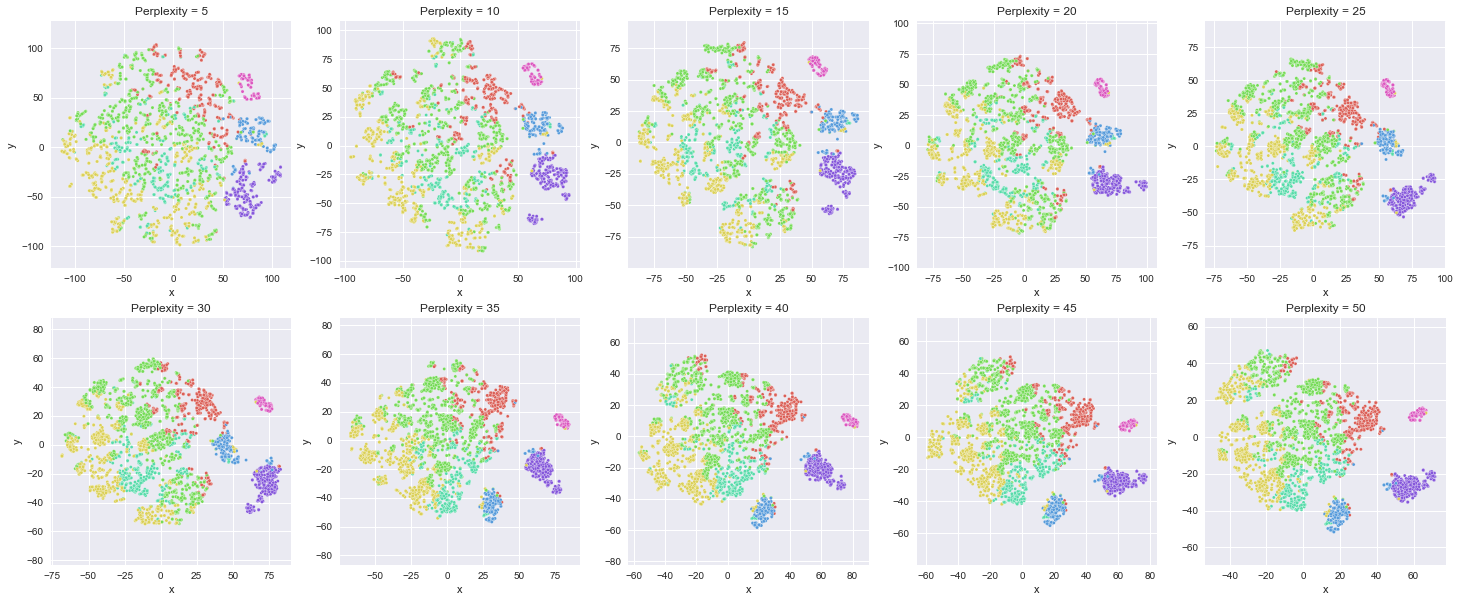

In [84]:
plot_perplexity_tsne(tsne_data_save,
                     loaded_model_v2_7,
                     data_scale,
                     color_from_labels=True,
                     savefig="perplexity_plots_v2_7")

Voir la [fonction](#plot_perplexity_tsne)


<a id='stacking'></a>
# Stacking PCA - t-SNE/k-Means

In [85]:
pca = decomposition.PCA(n_components=15)
data_scale_decomp = pca.fit_transform(data_scale)
print(pca.explained_variance_ratio_.cumsum())

[0.27671454 0.53391039 0.64953068 0.72363239 0.77101107 0.8155883
 0.85277122 0.880208   0.90319978 0.92447206 0.93911551 0.95082686
 0.95979598 0.96784297 0.97535306]


In [86]:
%%time
tsne = manifold.TSNE(init='pca', random_state=41, n_jobs=-1, perplexity=30)
data_tsne = tsne.fit_transform(data_scale_decomp)

Wall time: 15.1 s


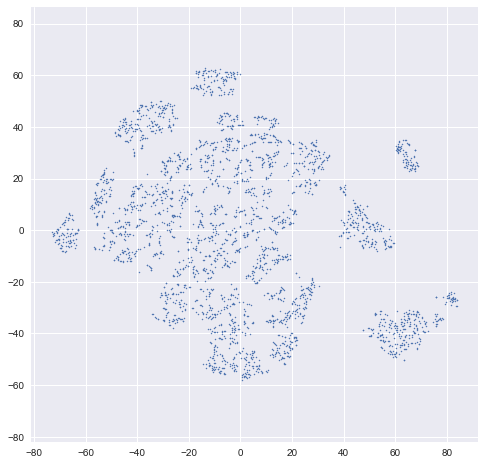

1.1285866498947144


In [87]:
x = [point[0] for point in data_tsne]
y = [point[1] for point in data_tsne]
plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne.kl_divergence_)

mlflow.create_experiment('pca_k_Means')

mlflow.set_experiment('pca_k_Means')
for n_clusters in np.arange(2,26):
    launch_kmeans(data_scale_decomp, {'n_clusters':n_clusters, 'random_state':41}, 'stacked_{}_clust'.format(n_clusters))

In [88]:
runs = mlflow.search_runs('5')

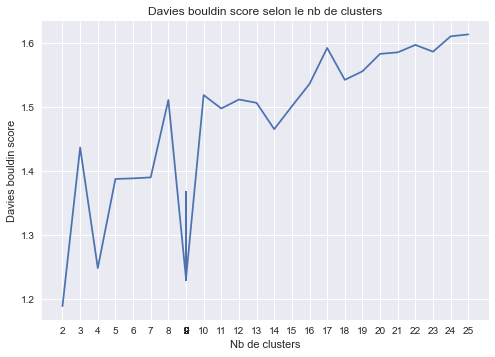

In [89]:
plot_n_clust_against_metric(runs, 'davies_bouldin_score', savefig='db_clust_kmeans_stacked')

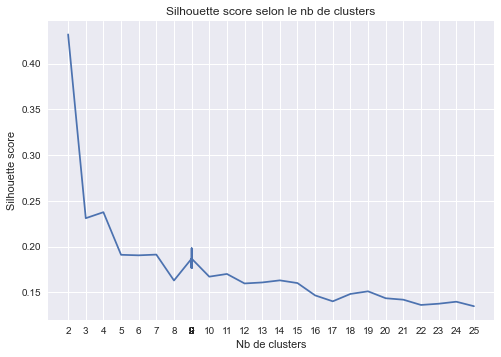

In [90]:
plot_n_clust_against_metric(runs, 'silhouette_score', savefig='silh_clust_kmeans_stacked')

Les resultats sont un petit peu meilleurs

### Avec 4 clusters

In [91]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/5/2465d0b4d16f4389b780593f06b63fe4/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_stacked_4 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


<a id='plot_scatter_tsne_back'></a>

4


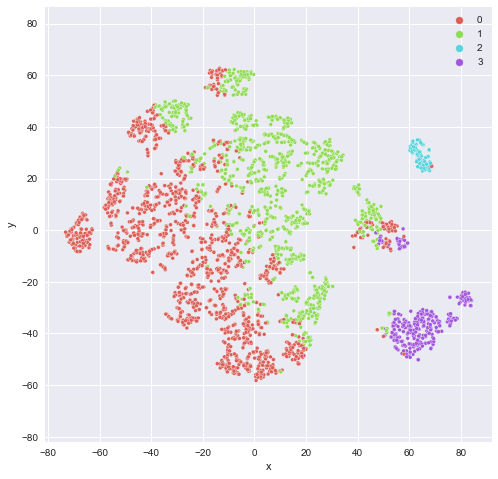

1.1285866498947144


In [92]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_stacked_4, data_scale_decomp)  

In [93]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/5/6b7ac6b1c3e442e4ae47f30c1f4b6c2e/artifacts/model'


# Load model as a PyFuncModel.
loaded_model_stacked_9 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


<a id='plot_scatter_tsne_back'></a>

9


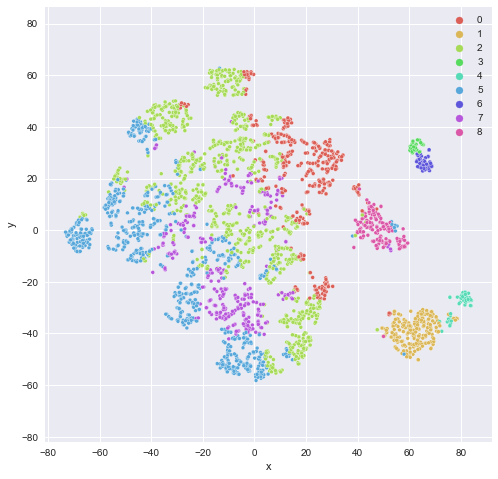

1.1285866498947144


In [94]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_stacked_9, data_scale_decomp)  

Voir [fonction](#plot_scatter_tsne)

In [95]:
tsne_data_save_decomp = {}
for perplexity in np.arange(5,55,5):
    tsne_test = manifold.TSNE(init='pca', 
                              random_state=41, 
                              n_jobs=-1, 
                              perplexity=perplexity)
    data_tsne_test = tsne_test.fit_transform(data_scale_decomp)
    tsne_data_save_decomp[perplexity] = data_tsne_test

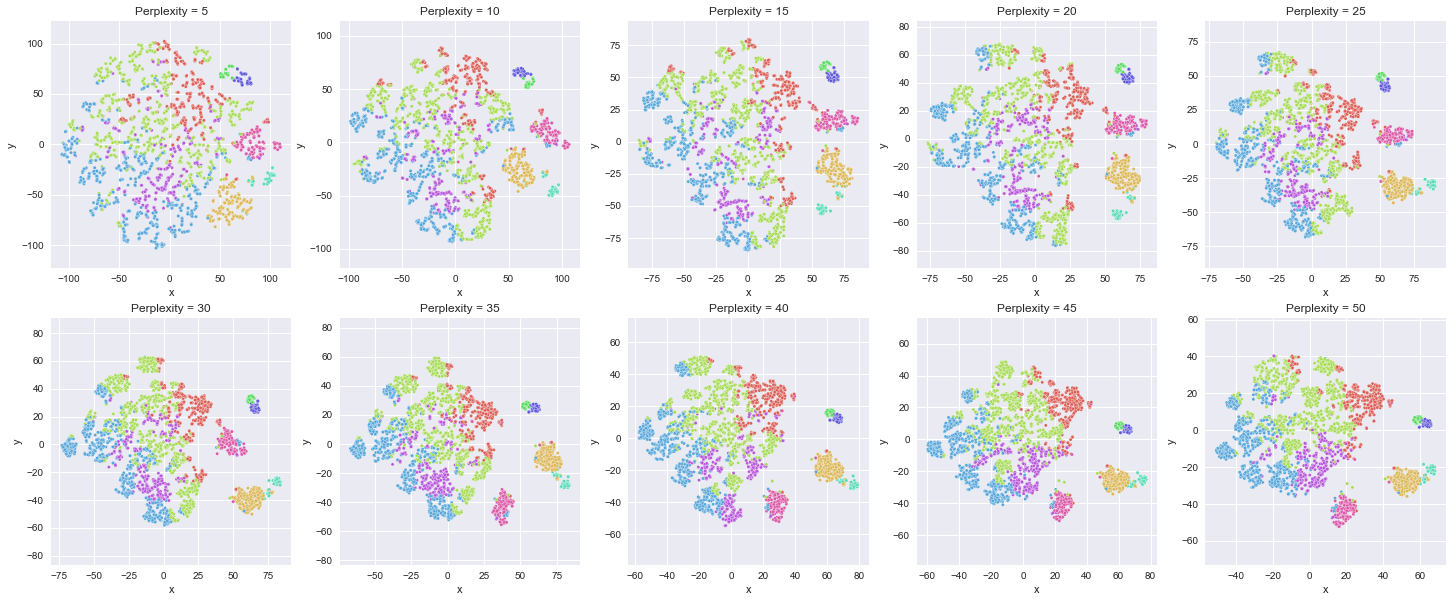

In [96]:
plot_perplexity_tsne(tsne_data_save_decomp,
                     loaded_model_stacked_9,
                     data_scale_decomp,
                     color_from_labels=True,
                     savefig="perplexity_plots_stacked_9")

<a id='DBSCAN_'></a>
# DBSCAN

In [97]:
def launch_dbscan(data, params, run_name):
    
    for eps in params['eps']:
        for min_samples in params['min_samples']:
            for metric in params['metric']:
                with mlflow.start_run(run_name=f'{run_name}_eps{eps}_ms{min_samples}_{metric}'):
                    #Create an estimator
                    model = DBSCAN(eps=eps,
                                   min_samples=min_samples,
                                   metric=metric,
                                   n_jobs=-1)
                    #Save params
                    for param, value in model.get_params().items():
                        mlflow.log_param(param, value)
                    #Fit
                    start = time.time()
                    model.fit(data)
                    elapsed = time.time() - start


                    #Save metrics
                    mlflow.log_metric('nb_clusters_found', len(set(model.labels_)) - (1 if -1 in model.labels_ else 0))
                    mlflow.log_metric('n_noise', list(model.labels_).count(-1))
                    mlflow.log_metric('training_time', elapsed)
                    try:
                        mlflow.log_metric('silhouette_score', metrics.silhouette_score(data, model.labels_))
                    except:
                        pass
                    try:
                        mlflow.log_metric('davies_bouldin_score', metrics.davies_bouldin_score(data, model.labels_))
                    except:
                        pass


                    #Save model
                    mlflow.sklearn.log_model(model, "model")

                    mlflow.end_run()

In [98]:
runs_dbscan = mlflow.search_runs('4')

In [99]:
runs_dbscan.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.n_noise', 'metrics.silhouette_score',
       'metrics.nb_clusters_found', 'metrics.davies_bouldin_score',
       'metrics.training_time', 'params.p', 'params.metric',
       'params.leaf_size', 'params.metric_params', 'params.eps',
       'params.algorithm', 'params.n_jobs', 'params.min_samples',
       'tags.mlflow.runName', 'tags.mlflow.user', 'tags.mlflow.source.name',
       'tags.mlflow.source.type', 'tags.mlflow.log-model.history'],
      dtype='object')

In [100]:
runs_dbscan = runs_dbscan[[
                         'metrics.silhouette_score', 
                         'metrics.n_noise',
                         'metrics.davies_bouldin_score',
                         'metrics.nb_clusters_found',
                         'params.eps',
                         'params.min_samples',
                         'params.metric'
                         ]]

In [101]:
runs_dbscan.groupby('params.metric').mean()

metrics.silhouette_score  metrics.n_noise  \
params.metric                                              
cosine                        -0.176827      1017.922222   
euclidean                     -0.317881      2621.388889   
l2                            -0.317881      2621.388889   
manhattan                     -0.360208      2878.544444   

               metrics.davies_bouldin_score  metrics.nb_clusters_found  
params.metric                                                           
cosine                             2.161986                  12.400000  
euclidean                          1.632956                  30.833333  
l2                                 1.632956                  30.833333  
manhattan                          1.535519                  20.833333

In [102]:
runs_dbscan.groupby('params.metric').max()

metrics.silhouette_score  metrics.n_noise  \
params.metric                                              
cosine                         0.332675           2997.0   
euclidean                     -0.108780           2997.0   
l2                            -0.108780           2997.0   
manhattan                     -0.223024           2997.0   

               metrics.davies_bouldin_score  metrics.nb_clusters_found  \
params.metric                                                            
cosine                             4.502299                      280.0   
euclidean                          2.221724                      289.0   
l2                                 2.221724                      289.0   
manhattan                          1.979317                      289.0   

              params.eps params.min_samples  
params.metric                                
cosine                 1                  8  
euclidean              1                  8  
l2                     1                  8  
manhattan              1                  8

In [103]:
runs_dbscan.groupby('params.metric').min()

metrics.silhouette_score  metrics.n_noise  \
params.metric                                              
cosine                        -0.515927              0.0   
euclidean                     -0.516103            506.0   
l2                            -0.516103            506.0   
manhattan                     -0.515457           1359.0   

               metrics.davies_bouldin_score  metrics.nb_clusters_found  \
params.metric                                                            
cosine                             0.730150                        0.0   
euclidean                          1.208698                        0.0   
l2                                 1.208698                        0.0   
manhattan                          1.250044                        0.0   

              params.eps params.min_samples  
params.metric                                
cosine            0.0001                 10  
euclidean         0.0001                 10  
l2                0.0001                 10  
manhattan         0.0001                 10

Quel modele chosir?

In [104]:
'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/4/a220d43fee794b50a298c6701947c647/artifacts/model'

'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/4/a220d43fee794b50a298c6701947c647/artifacts/model'

In [105]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/4/a220d43fee794b50a298c6701947c647/artifacts/model'


# Load model as a PyFuncModel.
loaded_model_stacked_dbscan_10 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DBSCAN from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [106]:
loaded_model_stacked_dbscan_10.labels_

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

<a id='plot_scatter_tsne_back'></a>

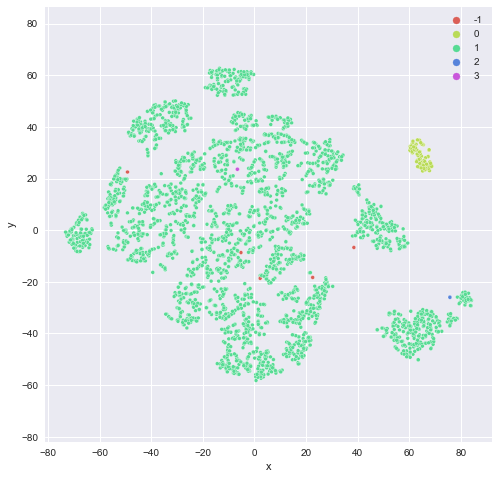

1.1285866498947144


In [115]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_stacked_dbscan_10, data_scale_decomp) 

<a id='hierarchique'></a>
# Clustering Hierarchique

In [116]:
def launch_hierarchical_clustering(data, params, run_name):
    
    for n_clusters in params['n_clusters']:
        for linkage in params['linkage']:
            for affinity in params['affinity']:
                if affinity != 'euclidean' and linkage == "ward":
                    break
                with mlflow.start_run(run_name=f'{run_name}_nclust_{n_clusters}_aff_{affinity}_link_{linkage}'):
                    #Create an estimator


                    model = AgglomerativeClustering(n_clusters=n_clusters,
                                                    affinity=affinity,
                                                    linkage=linkage,
                                                    )
                    #Save params
                    for param, value in model.get_params().items():
                        mlflow.log_param(param, value)
                    #Fit
                    start = time.time()
                    model.fit(data)
                    elapsed = time.time() - start


                    #Save metrics


                    mlflow.log_metric('training_time', elapsed)
                    mlflow.log_metric('n_leaves', model.n_leaves_)
                    try:
                        mlflow.log_metric('silhouette_score', metrics.silhouette_score(data, model.labels_))
                    except:
                        pass
                    try:
                        mlflow.log_metric('davies_bouldin_score', metrics.davies_bouldin_score(data, model.labels_))
                    except:
                        pass


                    #Save model
                    mlflow.sklearn.log_model(model, "model")

                    mlflow.end_run()

In [117]:
model = AgglomerativeClustering(n_clusters=5,
                                affinity='manhattan',
                                linkage='single',
                                compute_distances=True).fit(data_scale_decomp)

In [118]:
model.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

<a id='plot_scatter_tsne_back'></a>

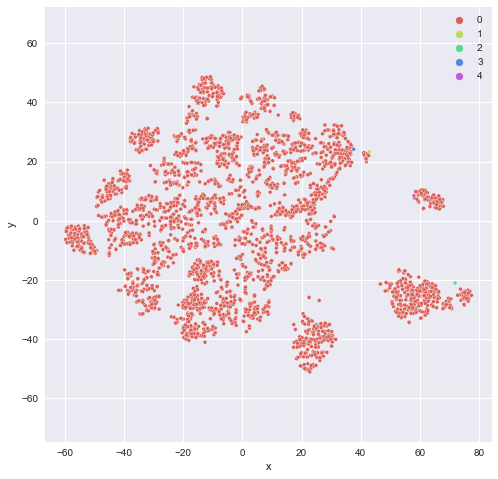

1.1285866498947144


In [119]:
plot_scatter_tsne_seaborn(tsne_data_save_decomp[45], model, data_scale_decomp)  

Voir [fonction](#plot_scatter_tsne)

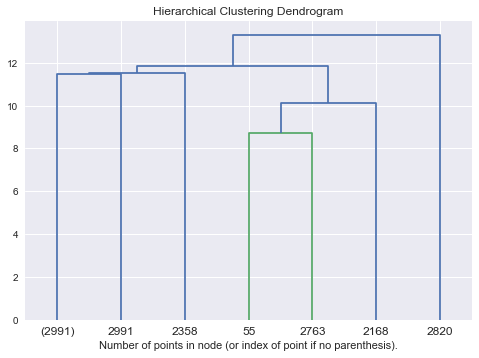

In [120]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

La méthode hierarchique est peu satisfaisante

<a id='choix'></a>
# Choix modèle

D'après les modélisations précédentes on peut choisir le modèle K-Means (9 clusters) après un PCA de 15 composantes

Nous appelerons la fonction ci dessous pour récupérer le modèle entrainé avec les données voulues

In [10]:
def pipeline_final(data, 
                   cols_categ, 
                   cols_numeric, 
                   n_clusters=9,
                   mode='model',
                   run_name=None,
                   experiment_name='pca_k_Means'):
    
    # FAIRE DOCSTRING
    scaler = StandardScaler().fit(data[cols_numeric])
    
    data_scale = pd.concat([pd.DataFrame(data=scaler.transform(data[cols_numeric]), 
                                         index=data.index, columns=cols_numeric), 
                            data[cols_categ]],
                           axis=1)
    pca = decomposition.PCA(n_components=15)
    data_scale_decomp = pca.fit_transform(data_scale)
    if mode == 'model':
        params = {'n_clusters':n_clusters, 'random_state':41}
        mlflow.set_experiment(experiment_name)
        model = launch_kmeans(data_scale_decomp, 
                              params, 
                              run_name)
        return model
    elif mode == 'data_process':
        return data_scale_decomp
    elif mode == 'data_labeled':
        params = {'n_clusters':n_clusters, 'random_state':41}
        mlflow.set_experiment(experiment_name)
        model = launch_kmeans(data_scale_decomp, 
                              params, 
                              run_name)
        cluster_labels = model.predict(data_scale_decomp)
        labeled_data = pd.DataFrame(data_scale, index=data.index, columns=data.columns)
        labeled_data["cluster"] = cluster_labels
        return labeled_data

# Test de la stabilité 
Determination de la fréquence de mise à jour du clustering

In [11]:
orders = pd.read_csv('data/olist_orders_dataset.csv', index_col='order_id',parse_dates=['order_purchase_timestamp', 
                                                                                        'order_approved_at',	
                                                                                        'order_delivered_carrier_date',	
                                                                                        'order_delivered_customer_date',
                                                                                        'order_estimated_delivery_date'])

In [12]:
orders.order_purchase_timestamp.max() - orders.order_purchase_timestamp.min()

Timedelta('772 days 20:14:59')

In [13]:
virtual_dates = pd.date_range(orders.order_purchase_timestamp.min(), 
                           orders.order_purchase_timestamp.max(), 
                           freq='SM',
                           normalize=True)

In [14]:
str(virtual_dates[0
             ].date())

'2016-09-15'

In [15]:
str(virtual_dates.max().date())



'2018-10-15'

In [16]:
def test_stability_mono_model(virtual_dates):
    
    last_data_set = pd.read_csv(f'data/timed_data/{str(virtual_dates.max().date())}.csv', index_col=[0])
    cols_numeric = last_data_set.loc[:,:'cancelation_rate'].columns
    cols_categ = last_data_set.loc[:,'baby':].columns
    print(last_data_set.shape)
    
    model = pipeline_final(last_data_set, 
                           cols_categ, 
                           cols_numeric, 
                           n_clusters=9,
                           mode='model',
                           run_name='test',
                           experiment_name='pca_k_Means')
    

    output_data = pd.DataFrame(data=np.full([2996,1], np.nan), 
                               columns=[virtual_dates[0]], 
                               index=last_data_set.index)
    
    for virtual_date in virtual_dates:
        
        virtual_date_str = str(virtual_date.date())
        try:
            virtual_date_data = pd.read_csv(f'data/timed_data/{virtual_date_str}.csv', index_col=[0])
            print(virtual_date_data.shape)
            virtual_date_data_scale_decomp = pipeline_final(virtual_date_data,
                                                           cols_categ, 
                                                           cols_numeric, 
                                                           mode='data_process')
            serie_out = pd.Series(model.predict(virtual_date_data_scale_decomp),
                                  index=virtual_date_data.index,
                                  name=virtual_date)
            
            output_data = output_data.merge(serie_out, 
                                              how='left',
                                              left_index=True,
                                              right_index=True)
#             data_dict[virtual_date_str] = model.predict(virtual_date_data_scale_decomp)
            
        except Exception as e:
            print(e)
            print(str(virtual_date.date()))
    
    return output_data

data_stability = test_stability_mono_model(virtual_dates)

(2996, 31)
[Errno 2] No such file or directory: 'data/timed_data/2016-09-15.csv'
2016-09-15
[Errno 2] No such file or directory: 'data/timed_data/2016-09-30.csv'
2016-09-30
(3, 31)
n_components=15 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'
2016-10-15
(3, 31)
n_components=15 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'
2016-10-31
(3, 31)
n_components=15 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'
2016-11-15
(3, 31)
n_components=15 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'
2016-11-30
(3, 31)
n_components=15 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'
2016-12-15
(3, 31)
n_components=15 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'
2016-12-31
(13, 31)
n_components=15 must be between 0 and min(n_samples, n_features)=13 with svd_solver='full'
2017-01-15
(27, 31)
(40, 31)
(53, 31)
(78, 31)
(99, 31)
(126, 31)
(146, 3

In [17]:
len(data_stability.columns)

43

In [18]:
data_stability.columns[1:-1][::-1]

DatetimeIndex(['2018-09-30', '2018-09-15', '2018-08-31', '2018-08-15',
               '2018-07-31', '2018-07-15', '2018-06-30', '2018-06-15',
               '2018-05-31', '2018-05-15', '2018-04-30', '2018-04-15',
               '2018-03-31', '2018-03-15', '2018-02-28', '2018-02-15',
               '2018-01-31', '2018-01-15', '2017-12-31', '2017-12-15',
               '2017-11-30', '2017-11-15', '2017-10-31', '2017-10-15',
               '2017-09-30', '2017-09-15', '2017-08-31', '2017-08-15',
               '2017-07-31', '2017-07-15', '2017-06-30', '2017-06-15',
               '2017-05-31', '2017-05-15', '2017-04-30', '2017-04-15',
               '2017-03-31', '2017-03-15', '2017-02-28', '2017-02-15',
               '2017-01-31'],
              dtype='datetime64[ns]', freq=None)

In [19]:
ARI = []
AMI = []
for index_date in range(len(data_stability.columns) - 1):
    pair_comparison = data_stability.iloc[:,index_date:index_date+2].dropna()
    ARI.append(metrics.adjusted_rand_score(pair_comparison.iloc[:,0], pair_comparison.iloc[:,1]))
    AMI.append(metrics.adjusted_mutual_info_score(pair_comparison.iloc[:,0], pair_comparison.iloc[:,1]))
    

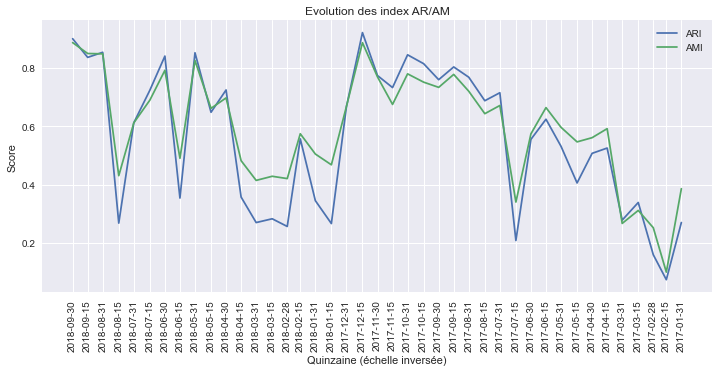

In [20]:
plt.figure(figsize=(12,5))
plt.title("Evolution des index AR/AM")
plt.plot(data_stability.columns[1:-1] , ARI[1:], label='ARI')
plt.plot(data_stability.columns[1:-1] , AMI[1:], label='AMI')
plt.xticks(data_stability.columns[1:-1], rotation=90)
plt.xlabel('Quinzaine (échelle inversée)')
plt.ylabel('Score')
plt.gca().invert_xaxis()
plt.legend()
# plt.savefig('plots/ami_ari.png', bbox_inches='tight', dpi=360)
plt.show()

In [21]:
data_stability.columns

DatetimeIndex(['2016-09-15', '2017-01-31', '2017-02-15', '2017-02-28',
               '2017-03-15', '2017-03-31', '2017-04-15', '2017-04-30',
               '2017-05-15', '2017-05-31', '2017-06-15', '2017-06-30',
               '2017-07-15', '2017-07-31', '2017-08-15', '2017-08-31',
               '2017-09-15', '2017-09-30', '2017-10-15', '2017-10-31',
               '2017-11-15', '2017-11-30', '2017-12-15', '2017-12-31',
               '2018-01-15', '2018-01-31', '2018-02-15', '2018-02-28',
               '2018-03-15', '2018-03-31', '2018-04-15', '2018-04-30',
               '2018-05-15', '2018-05-31', '2018-06-15', '2018-06-30',
               '2018-07-15', '2018-07-31', '2018-08-15', '2018-08-31',
               '2018-09-15', '2018-09-30', '2018-10-15'],
              dtype='datetime64[ns]', freq=None)

In [22]:
def test_stability_multi_model(virtual_dates):
    
    for virtual_date in virtual_dates:
        #Extraire données
        try:
            data_virtual_date = pd.read_csv(f'data/timed_data/{str(virtual_date.date())}.csv', index_col=[0])
        except:
            continue
        cols_numeric = data_virtual_date.loc[:,:'cancelation_rate'].columns
        cols_categ = data_virtual_date.loc[:,'baby':].columns
        
        #Préparer données et lancer modele
        try:
            model = pipeline_final(data_virtual_date, 
                                   cols_categ, 
                                   cols_numeric, 
                                   n_clusters=9,
                                   mode='model',
                                   run_name=str(virtual_date.date()),
                                   experiment_name='stability_multi_model_2')
        except:
            continue
        
        
    #Stocker scores
    runs = mlflow.search_runs('8')

    return runs[['metrics.davies_bouldin_score', 'metrics.silhouette_score']]


In [23]:
runs = mlflow.search_runs('8')
scores = runs[['tags.mlflow.runName', 'metrics.davies_bouldin_score', 'metrics.silhouette_score']]

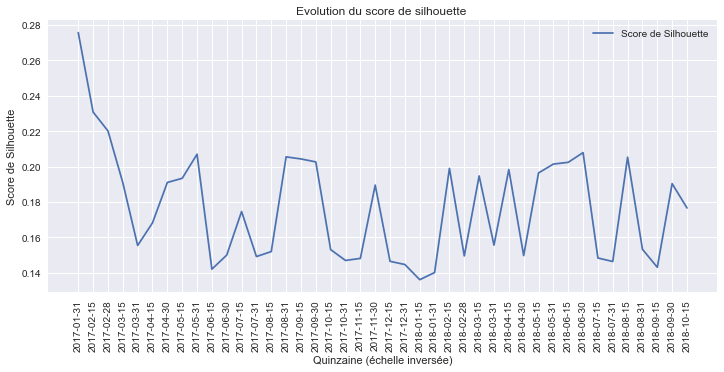

In [24]:
plt.figure(figsize=(12,5))
plt.title("Evolution du score de silhouette ")
plt.plot(scores['tags.mlflow.runName'] , scores['metrics.silhouette_score'], label='Score de Silhouette')
plt.xticks(scores['tags.mlflow.runName'], rotation=90)
plt.xlabel('Quinzaine (échelle inversée)')
plt.ylabel('Score de Silhouette')
plt.gca().invert_xaxis()
plt.legend()
# plt.savefig('plots/stability_silhouette.png', bbox_inches='tight', dpi=360)
plt.show()

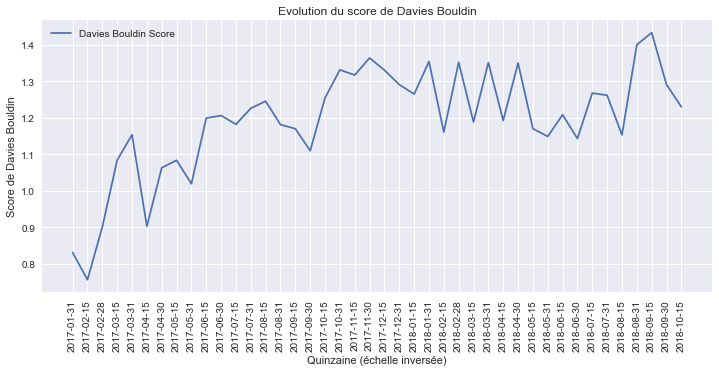

In [25]:
plt.figure(figsize=(12,5))
plt.title("Evolution du score de Davies Bouldin")
plt.plot(scores['tags.mlflow.runName'] , scores['metrics.davies_bouldin_score'], label='Davies Bouldin Score')
plt.xticks(scores['tags.mlflow.runName'], rotation=90)
plt.xlabel('Quinzaine (échelle inversée)')
plt.ylabel('Score de Davies Bouldin')
plt.legend()
plt.gca().invert_xaxis()
# plt.savefig('plots/stability_DB.png', bbox_inches='tight', dpi=360)
plt.show()

# Interpretation du dernier modèle

Fonctions issues du cours OC en anglais de Llewelyn Fernandes sur le K-Means

In [26]:
data_to_interpret = pd.read_csv(f'data/timed_data/{str(virtual_dates.max().date())}.csv', index_col=[0])

In [27]:
data_to_interpret.columns

Index(['nb_orders', 'days_since_first_order', 'days_since_last_order',
       'frequency', 'sum_orders', 'nb_reviews', 'average_review_score',
       'average_delivery_time', 'delay_rate', 'advance_rate',
       'cancelation_rate', 'baby', 'electronics', 'fashion', 'furniture',
       'health_beauty', 'home_confort', 'industry', 'other', 'pet_shop',
       'sports_leisure', 'watches_gifts_toys', 'arts_and_craftmanship',
       'culture', 'home_construction', 'auto', 'food_drink', 'cash',
       'credit_card', 'debit_card', 'voucher'],
      dtype='object')

In [28]:
labeled_data = pipeline_final(data_to_interpret, 
                               cols_numeric = data_to_interpret.loc[:,:'cancelation_rate'].columns,
                                cols_categ = data_to_interpret.loc[:,'baby':].columns,
                               n_clusters=9,
                               mode='data_labeled',
                               run_name=None,
                               experiment_name='pca_k_Means')

In [29]:
cols_numeric = data_to_interpret.loc[:,:'cancelation_rate'].columns
cols_numeric_list = list(cols_numeric)
cols_numeric_list.append('cluster')
cols_numeric_index = pd.Index(cols_numeric_list)
cols_categ = data_to_interpret.loc[:,'baby':].columns
cols_categ_list = list(cols_categ)
cols_categ_list.append('cluster')
cols_categ_index = pd.Index(cols_categ_list)

In [30]:
model = pipeline_final(data_to_interpret, 
                               cols_numeric = data_to_interpret.loc[:,:'cancelation_rate'].columns,
                                cols_categ = data_to_interpret.loc[:,'baby':].columns,
                               n_clusters=9,
                               mode='model',
                               run_name=None,
                               experiment_name='pca_k_Means')

In [32]:
clf_categ = NearestCentroid()
X_categ = labeled_data[cols_categ_index].drop(columns=['cluster'])
y_categ = labeled_data[cols_categ_index]['cluster']
clf_categ.fit(X_categ, y_categ)

NearestCentroid()

In [33]:
clf_numeric = NearestCentroid()
X_num = labeled_data[cols_numeric_index].drop(columns=['cluster'])
y_num = labeled_data[cols_numeric_index]['cluster']
clf_numeric.fit(X_num, y_num)

NearestCentroid()

In [34]:
cols_categ

Index(['baby', 'electronics', 'fashion', 'furniture', 'health_beauty',
       'home_confort', 'industry', 'other', 'pet_shop', 'sports_leisure',
       'watches_gifts_toys', 'arts_and_craftmanship', 'culture',
       'home_construction', 'auto', 'food_drink', 'cash', 'credit_card',
       'debit_card', 'voucher'],
      dtype='object')

In [35]:
cols_numeric_index

Index(['nb_orders', 'days_since_first_order', 'days_since_last_order',
       'frequency', 'sum_orders', 'nb_reviews', 'average_review_score',
       'average_delivery_time', 'delay_rate', 'advance_rate',
       'cancelation_rate', 'cluster'],
      dtype='object')

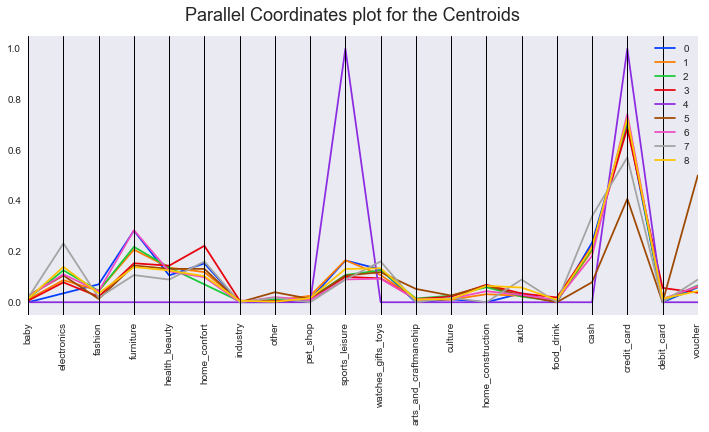

In [38]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(clf_categ.centroids_, columns=cols_categ)
centroids['cluster'] = clf_categ.classes_

display_parallel_coordinates_centroids(centroids, 9, stagger=False)
plt.xticks(rotation=90)
# plt.savefig('plots/interpretation_categs.png', bbox_inches='tight', dpi=360)
plt.show()

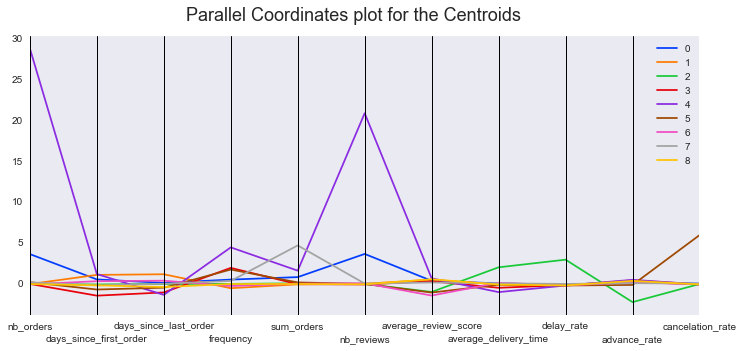

In [39]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(clf_numeric.centroids_, columns=cols_numeric)
centroids['cluster'] = clf_numeric.classes_

display_parallel_coordinates_centroids(centroids, 9)
# plt.savefig('plots/interpretation_num_features.png', bbox_inches='tight', dpi=360)

- Cluster 0 : Clients plutot actifs, préfèrent les achats de type meubles
- Cluster 1 : Clients inactifs longtemps 
- Cluster 2 : Clients difficile à livrer
- Cluster 3 : Home confort, nouveaux clients
- Cluster 4 : Clients les plus fidèles, sport et loisirs
- Cluster 5 : Clients payant avec des voucher, ceux qui annulent le plus, arts créatifs
- Cluster 6 : Achats meubles, clients peu satisfaits
- Cluster 7 : Electronique, auto, plus grosses dépenses
- Cluster 8 : Difficile à dire